In [1]:
# This notebook shows how you can train your model and analyze it using lla library
# You can import your loader from loaders to plot loss landscapes and/or evaluate hessian

# This library is distributed under Apache 2.0 license

# (c) Kryptonite, 2024

In [2]:
import copy
import argparse
import os
import random
import warnings

import torch
import torch.optim as optim

# import the main loss landscape analysis function
from src_lla import viz_lla

#import your loader here
#from src_lla.loaders.src_ResNet import *
#from src_lla.loaders.src_mlp_mnist import *
from src_lla.loaders.src_LeNet import *

import matplotlib
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
exp_name = 'default'
data_path = '-1'
viz_dir = 'viz_results'
log_dir = 'train_logs'
weight_path = '-1'
num_plots = 2
num_per_plot = 2
epochs = 1
lr = 0.01
viz_rate = 1
mode = 'add'
normalization = None
order = 2
dist = 1
steps = 40
all_modes = False
cap_loss = None
axes = 'random'
eval_hessian = False
seed = None
raa = None

to_save = False
to_viz = True

In [4]:
if to_save:
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(viz_dir):
        os.makedirs(viz_dir)

In [5]:
seed = 42

if seed is not None:
    random.seed(seed)
    #if np is not None:
    #    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [6]:
viz_dev = all_modes
calc_train_acc = True

In [7]:
cuda = True

In [8]:
if cuda:
    print('checking if cuda is available...')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == 'cpu':
        print('Warning! --cuda was specified but cuda is not available!')
else:
    device = 'cpu'
print("Project running on device: ", device)

checking if cuda is available...
Project running on device:  cuda


In [9]:
allowed_axes = ['random', 'adam', 'hessian']

if axes not in allowed_axes:
    print('{} argument for axes is not supported, allowed {}!'.format(axes,allowed_axes))
    print('setting axes to random')
    axes = 'random'

if axes == 'hessian' and mode == 'adameq':
    warnings.warn('Using Adam equation update for Hessian axes will lead to unpredictable results!')
    warnings.warn('Setting mode to add')
    mode = 'add'

if (axes == 'random' or axes == 'hessian') and (mode == 'moment' or mode == 'adameq'):
    warnings.warn('Using Adam update equation for random or hessian axes will lead to unpredictable results')
    #print('!!!WARNING!!! Using Adam update equation for random axes vectors will lead to unpredictable results')

if axes == 'random' and viz_dev:
    print('all_modes requires adam moment axes calculation, setting axes to adam!')
    axes = 'adam'

if axes == 'hessian' and viz_dev:
    #print('!!!WARNING!!! using axes = hessian with all_modes is currently not supported since all_modes uses adam axes!')
    print('Using Hessian eigenvector axes instead of Adam moment axes for all_modes')

In [10]:
# init train_loader
if data_path != '-1':
    train_loader = CustomLoader(shuffle=True,data_path=data_path)
else: # use default data path specified in loader
    train_loader = CustomLoader(shuffle=True)

# model can take other arguments, but it MUST take device
# note that weight_path = None is a valid option used for random weight init
if weight_path != '-1':
    model = ModelInit(device=device,weight_path=weight_path)
else:
    model = ModelInit(device=device)

# create metric object
x_plot, y_plot = iter(train_loader).__next__() # data that the evaluator will use when evaluating loss
metric = CustomLoss(x_plot, y_plot, device) # loss evaluator
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
model.train()
train_loss = 0.0

for epoch in range(epochs):
    cor = 0
    for i, batch in enumerate(train_loader):

        # using metric.forward to do inference and calc preds and loss
        optimizer.zero_grad()
        loss, preds = metric(None,model=model,batch=batch,use_wrapper=False,return_pred=True)
        
        if calc_train_acc:
            # modify if labels!=batch[1]
            labels = batch[1].to(device)
        
            pred_labels = torch.argmax(preds, dim=1)
            cor += pred_labels[pred_labels == labels].shape[0]
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    if calc_train_acc:
        cur_train_acc = cor/(len(train_loader)*train_loader.batch_size)
        print('train accuracy at epoch {}: {}'.format(epoch,cur_train_acc))
    
    ### loss landscape analysis starts here, no need to modify ###
    if epoch % viz_rate == 0 or epoch == epochs-1:
        print('saving results for epoch ', epoch)
        #model.eval() 
        cur_name = exp_name + '_epoch_' + str(epoch)
        
        viz_lla(model=model, metric=metric, device=device, dist=dist, steps=steps,  num_plots = num_plots, num_per_plot=num_per_plot, 
                axes=axes, normalization=normalization, order=order, cur_name=cur_name, mode=mode, viz_dev=viz_dev, 
                cap_loss=cap_loss, raa=raa, viz_dir=viz_dir, eval_hessian=eval_hessian, optimizer=optimizer, to_save=to_save,to_viz=False)
        
        #model.train()
    
    cur_loss = train_loss / ((epoch+1)*len(train_loader)) # / batch_size?!
    
    if to_save:
        with open(os.path.join(log_dir,'{}.log'.format(exp_name)), 'a') as log_file:
            if calc_train_acc:
                log_file.write('Loss at epoch {}: {}; train accuracy: {}\n'.format(epoch+1,cur_loss,cur_train_acc))
            else:
                log_file.write('Loss at epoch {}: {}\n'.format(epoch+1,cur_loss))

train accuracy at epoch 0: 0.7077047413793104
saving results for epoch  0


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


taking dirs from Hessian...


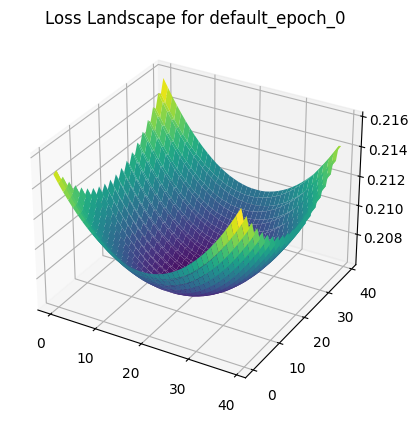

In [12]:
viz_lla(model=model, metric=metric, device=device, dist=dist, steps=steps,  num_plots = 4, num_per_plot=2, 
        axes='hessian', normalization='weight', order=order, cur_name=cur_name, mode=mode, viz_dev=False, 
        cap_loss=cap_loss, raa=raa, viz_dir=viz_dir, eval_hessian=eval_hessian, optimizer=optimizer, to_save=to_save,to_viz=to_viz)

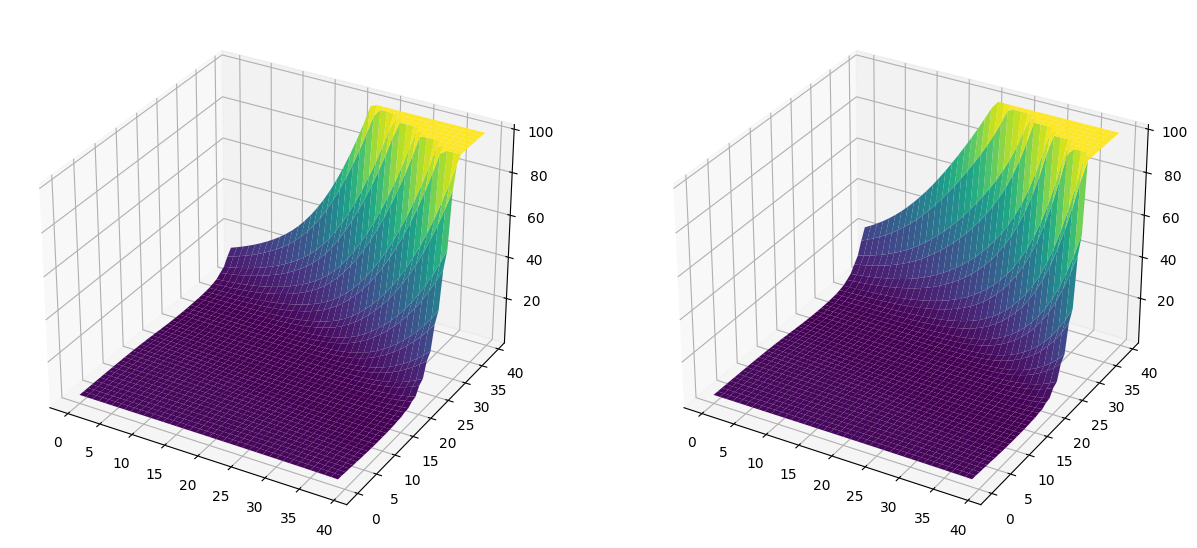

In [13]:
viz_lla(model=model, metric=metric, device=device, dist=dist, steps=steps,  num_plots = 2, num_per_plot=2, 
        axes='random', normalization='filter', order=order, cur_name=cur_name, mode=mode, viz_dev=False, 
        cap_loss=100, raa=raa, viz_dir=viz_dir, eval_hessian=eval_hessian, optimizer=optimizer, to_save=to_save,to_viz=to_viz)